# Tutorial 7b - Surface Roughness & Scattering

### August 2024

This tutorial demonstrates how surface roughness and scattering can be configured on surfaces in Optiland. We will compare singlets with the following scattering properties assigned:

- No scattering
- Gaussian Scattering
- Lambertian Scattering

The scattering model is defined via the Bidirectional Scattering Distribution Function, or BSDF.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from optiland import optic, scatter

Preparation

We first define a generic singlet class that accepts a bsdf as an input. In this example, we assign the scattering only to the rear surface.

In [2]:
class SingletConfigurable(optic.Optic):
    def __init__(self, bsdf):
        super().__init__()

        # add surfaces
        self.add_surface(index=0, radius=np.inf, thickness=np.inf)
        self.add_surface(
            index=1,
            thickness=7,
            radius=50,
            is_stop=True,
            material="N-SF11",
        )
        self.add_surface(index=2, thickness=50, bsdf=bsdf)  # <-- add bsdf here
        self.add_surface(index=3)

        # add aperture
        self.set_aperture(aperture_type="EPD", value=25.4)

        # add field
        self.set_field_type(field_type="angle")
        self.add_field(y=0)
        self.add_field(y=10)
        self.add_field(y=14)

        # add wavelength
        self.add_wavelength(value=0.48613270)
        self.add_wavelength(value=0.58756180, is_primary=True)
        self.add_wavelength(value=0.65627250)

        self.image_solve()  # solve for image plane

Let's also define a helper function to plot a 2D distribution of rays intersection points.

In [3]:
def plot_ray_distribution(rays, bins=128):
    x = rays.x
    y = rays.y
    i = rays.i

    plt.hist2d(x, y, weights=i, bins=bins, cmap="viridis")
    plt.colorbar()
    plt.xlabel("X (mm)")
    plt.ylabel("Y (mm)")
    plt.title("2D Ray Distribution on Image Plane")
    plt.show()

1. Singlet #1 - No Surface Scattering

The first singlet we analyze will have no scattering applied. Let's first define the lens and draw it.

In [4]:
singlet_no_scatter = SingletConfigurable(bsdf=None)

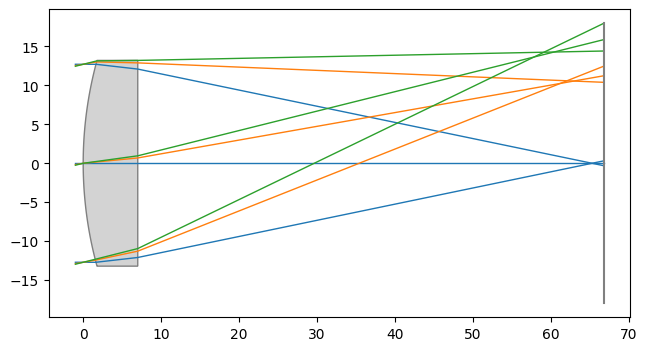

In [5]:
singlet_no_scatter.draw()

Let's trace 1 million random rays through the lens at the on-axis field point and look at the distribution.

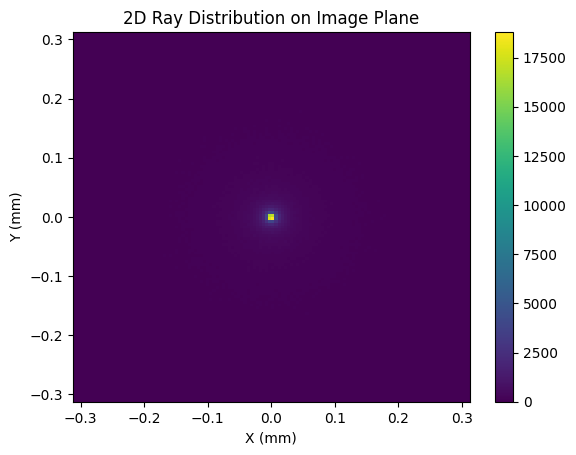

In [6]:
rays = singlet_no_scatter.trace(
    Hx=0,
    Hy=0,
    wavelength=0.58756180,
    num_rays=1_000_000,
    distribution="random",
)

plot_ray_distribution(rays, bins=128)

As we can see, the energy is largely located at the origin on the image plane. Let's see how this is implacted when scattering is introduced.

2. Singlet #2 - Gaussian Scattering

Gaussian scattering is defined by a 2D Gaussian distribution with a user-defined sigma (std. dev.) value. The larger the value of sigma, the closer the scattering model comes to Lambertian. We define a GaussianBSDF model with a sigma value of 0.01 and generate a new singlet:

In [7]:
bsdf = scatter.GaussianBSDF(sigma=0.01)
singlet_gaussian = SingletConfigurable(bsdf=bsdf)

Again, we trace 1 million rays and view the distribution at the image plane:

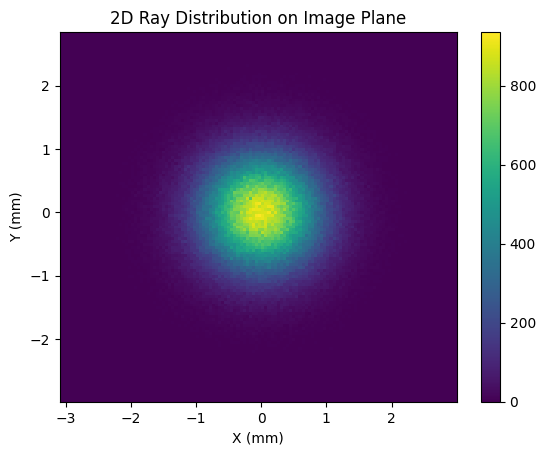

In [8]:
rays = singlet_gaussian.trace(
    Hx=0,
    Hy=0,
    wavelength=0.58756180,
    num_rays=1_000_000,
    distribution="random",
)

plot_ray_distribution(rays)

The image size has blurred significantly in comparison to the no-scattering case. Note that the plot axis spans a larger range here as well.

3. Singlet #3 - Lambertian Scattering

Lambertian scattering implies that the surface scatters incident light uniformly in all directions. Diffuse surfaces can be considered approximately Lambertian. To model a Lambertian scatterer in Optiland, we simply define the LambertianBSDF model and pass it to our singlet:

In [9]:
bsdf = scatter.LambertianBSDF()
singlet_lambertian = SingletConfigurable(bsdf=bsdf)

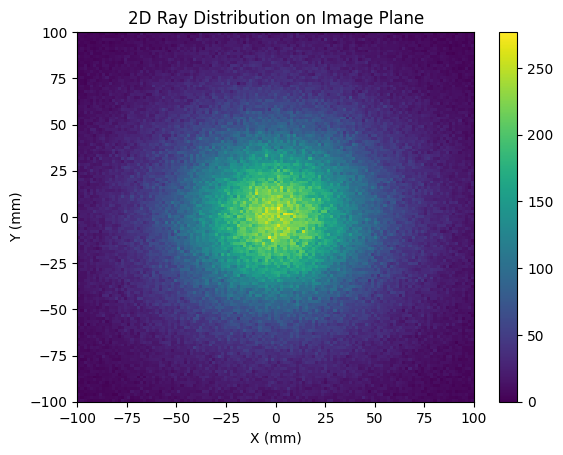

In [10]:
rays = singlet_lambertian.trace(
    Hx=0,
    Hy=0,
    wavelength=0.58756180,
    num_rays=1_000_000,
    distribution="random",
)

plot_ray_distribution(rays, bins=np.linspace(-100, 100, 128))

In this case, we are plotting the image plane over a significantly larger area, from -100 mm to 100 mm. Clearly, the Lambertian scatter model has dramatically increased the spot size at the image plane.

4. Conclusions:

- We introduced two BSDF scatter models: Gaussian and Lambertian.
- Scatter models can be used to model and understand the impact of manufacturing defects, such as surface roughness on optical surfaces.